In [773]:
# Loading libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from google.colab import files
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [774]:
# Loading dataset
!wget https://raw.githubusercontent.com/brodzy/chess-predictor/main/games.csv
chess_data = pd.read_csv("games.csv") # Kaggle Chess Game Dataset (Lichess)

--2022-11-28 03:15:16--  https://raw.githubusercontent.com/brodzy/chess-predictor/main/games.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7672655 (7.3M) [text/plain]
Saving to: ‘games.csv.38’

games.csv.38        100%[===================>]   7.32M  --.-KB/s    in 0.06s   

2022-11-28 03:15:16 (116 MB/s) - ‘games.csv.38’ saved [7672655/7672655]



In [775]:
# Every 2 points represents 1 move in chess, splitting moves into indices
moves = chess_data.moves.str.split(n=10, expand=True)
moves

,0,1,2,3,4,5,6,7,8,9,10
0,d4,d5,c4,c6,cxd5,e6,dxe6,fxe6,Nf3,Bb4+,Nc3 Ba5 Bf4
1,d4,Nc6,e4,e5,f4,f6,dxe5,fxe5,fxe5,Nxe5,Qd4 Nc6 Qe5+ Nxe5 c4 Bb4+
2,e4,e5,d3,d6,Be3,c6,Be2,b5,Nd2,a5,a4 c5 axb5 Nc6 bxc6 Ra6 Nc4 a4 c3 a3 Nxa3 Rxa3...
3,d4,d5,Nf3,Bf5,Nc3,Nf6,Bf4,Ng4,e3,Nc6,Be2 Qd7 O-O O-O-O Nb5 Nb4 Rc1 Nxa2 Ra1 Nb4 Nxa...
4,e4,e5,Nf3,d6,d4,Nc6,d5,Nb4,a3,Na6,Nc3 Be7 b4 Nf6 Bg5 O-O b5 Nc5 Bxf6 Bxf6 Bd3 Qd...
...,...,...,...,...,...,...,...,...,...,...,...
20053,d4,f5,e3,e6,Nf3,Nf6,Nc3,b6,Be2,Bb7,O-O Be7 Ne5 d6 Bh5+ g6 Nxg6 hxg6 Bxg6+ Kf8 e4 ...
20054,d4,d6,Bf4,e5,Bg3,Nf6,e3,exd4,exd4,d5,c3 Bd6 Bd3 O-O Nd2 Re8+ Kf1 Bxg3 hxg3 b6 g4 Ba...
20055,d4,d5,Bf4,Nc6,e3,Nf6,c3,e6,Nf3,Be7,Bd3 O-O Nbd2 b6 Ne5 Nxe5 Bxe5 Nd7 Bxh7+ Kxh7 Q...
20056,e4,d6,d4,Nf6,e5,dxe5,dxe5,Qxd1+,Kxd1,Nd5,c4 Nb6 c5 Nd5 Bc4 e6 Bxd5 exd5 Nc3 d4 Ne4 Bf5 ...


In [776]:
# Extracting moves from data, every even index is white, every odd index is black
chess_data['move_1'] = moves[0] + moves[1]
chess_data['move_2'] = moves[2] + moves[3]
chess_data['move_3'] = moves[4] + moves[5]
chess_data['move_4'] = moves[6] + moves[7]
chess_data['move_5'] = moves[8] + moves[9]

In [777]:
# Mapping the probability of winning on move 1 with respect to black
prob_move_1 = pd.crosstab([chess_data.move_1], columns = chess_data.winner, normalize = 'index')
chess_data['move_1'] = chess_data['move_1'].map(dict(prob_move_1['black']))

# Mapping the probability of winning on move 2 with respect to black
prob_move_2 = pd.crosstab([chess_data.move_2], columns = chess_data.winner, normalize = 'index')
chess_data['move_2'] = chess_data['move_2'].map(dict(prob_move_2['black']))

# Mapping the probability of winning on move 3 with respect to black
prob_move_3 = pd.crosstab([chess_data.move_3], columns = chess_data.winner, normalize = 'index')
chess_data['move_3'] = chess_data['move_3'].map(dict(prob_move_3['black']))

# Mapping the probability of winning on move 4 with respect to black
prob_move_4 = pd.crosstab([chess_data.move_4], columns = chess_data.winner, normalize = 'index')
chess_data['move_4'] = chess_data['move_4'].map(dict(prob_move_4['black']))

# Mapping the probability of winning on move 5 with respect to black
prob_move_5 = pd.crosstab([chess_data.move_5], columns = chess_data.winner, normalize = 'index')
chess_data['move_5'] = chess_data['move_5'].map(dict(prob_move_5['black']))


In [778]:
chess_data

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,black_rating,moves,opening_eco,opening_name,opening_ply,move_1,move_2,move_3,move_4,move_5
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,...,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,0.452174,0.450549,0.000000,0.583333,0.384615
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,...,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,0.517857,0.363636,0.500000,0.235294,1.000000
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,...,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,0.434898,0.485714,0.000000,0.000000,0.000000
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,...,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,0.452174,0.428571,0.482650,0.000000,0.516129
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,...,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,0.434898,0.427326,0.390476,0.307692,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,EfqH7VVH,True,1.499791e+12,1.499791e+12,24,resign,white,10+10,belcolt,1691,...,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2,0.467890,0.509091,0.455357,0.357143,0.500000
20054,WSJDhbPl,True,1.499698e+12,1.499699e+12,82,mate,black,10+0,jamboger,1233,...,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2,0.400000,0.250000,1.000000,0.500000,1.000000
20055,yrAas0Kj,True,1.499698e+12,1.499698e+12,35,mate,white,10+0,jamboger,1219,...,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3,0.452174,0.402778,0.450262,0.619048,0.528302
20056,b0v4tRyF,True,1.499696e+12,1.499697e+12,109,resign,white,10+0,marcodisogno,1360,...,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4,0.397101,0.475138,0.562500,0.714286,0.000000


In [779]:
# Mapping the probability of winning on each opening with respect to black
chess_opening_data = pd.crosstab(chess_data.opening_eco, columns = chess_data.winner, normalize = 'index')
chess_data['opening_eco'] = chess_data['opening_eco'].map(dict(chess_opening_data['black']))

In [780]:
# Converting strings to be numerical for testing
chess_data.replace({'white' : 0, 'black': 1, 'draw': 0}, inplace = True)
chess_data.replace({False: 0, True: 1}, inplace = True)

# Cleaning columns
chess_data.drop(columns = ['created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id', 'opening_name', 'id','victory_status', 'turns', 'moves'], axis = 1, inplace =True)
chess_data = chess_data.dropna().copy()

In [781]:
chess_data

,rated,winner,white_rating,black_rating,opening_eco,opening_ply,move_1,move_2,move_3,move_4,move_5
0,0,0,1500,1191,0.527273,5,0.452174,0.450549,0.000000,0.583333,0.384615
1,1,1,1322,1261,0.356792,4,0.517857,0.363636,0.500000,0.235294,1.000000
2,1,0,1496,1500,0.525926,3,0.434898,0.485714,0.000000,0.000000,0.000000
3,1,0,1439,1454,0.444700,3,0.452174,0.428571,0.482650,0.000000,0.516129
4,1,0,1523,1469,0.386397,5,0.434898,0.427326,0.390476,0.307692,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
20053,1,0,1691,1220,0.418182,2,0.467890,0.509091,0.455357,0.357143,0.500000
20054,1,1,1233,1196,0.400000,2,0.400000,0.250000,1.000000,0.500000,1.000000
20055,1,0,1219,1286,0.487145,3,0.452174,0.402778,0.450262,0.619048,0.528302
20056,1,0,1360,1227,0.384868,4,0.397101,0.475138,0.562500,0.714286,0.000000


In [782]:
# Create 80% train / 20% test split
X = chess_data.drop('winner', axis = 1) # Made sure to drop winner otherwise accuracy would be 100%
y = chess_data['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = None, stratify = y)

# Standardize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [783]:
# KNN Implementation
knn_model = KNeighborsClassifier(5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
y_score_knn = knn_model.predict_proba(X_test_scaled)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      2114
           1       0.72      0.71      0.72      1775

    accuracy                           0.74      3889
   macro avg       0.74      0.74      0.74      3889
weighted avg       0.74      0.74      0.74      3889



In [784]:
# AdaBoost Implementation
adab_model = AdaBoostClassifier()
adab_model.fit(X_train_scaled, y_train)
y_pred_adab = adab_model.predict(X_test_scaled)
y_score_adab = adab_model.predict_proba(X_test_scaled)

print(classification_report(y_test, y_pred_adab))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      2114
           1       0.75      0.74      0.75      1775

    accuracy                           0.77      3889
   macro avg       0.77      0.77      0.77      3889
weighted avg       0.77      0.77      0.77      3889



In [785]:
# SVC Implementation
svc_model = SVC(probability = True)
svc_model.fit(X_train_scaled, y_train)
y_pred_svc = svc_model.predict(X_test_scaled)
y_score_svc = svc_model.predict_proba(X_test_scaled)

print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      2114
           1       0.78      0.74      0.76      1775

    accuracy                           0.79      3889
   macro avg       0.78      0.78      0.78      3889
weighted avg       0.78      0.79      0.78      3889



In [786]:
# Confusion Matrix
def plotCM(cm, name):
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='BrBG');
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.set_title('Confusion Matrix of ' + name); 
  ax.xaxis.set_ticklabels(['1', '0']) 
  ax.yaxis.set_ticklabels(['1', '0'])

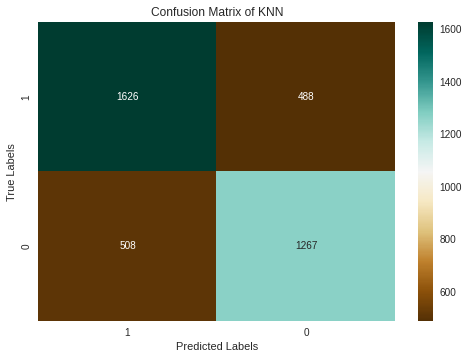

In [787]:
# Plot CM KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
plotCM(cm_knn, 'KNN')
plt.savefig('KNN_CM.png', dpi=300)

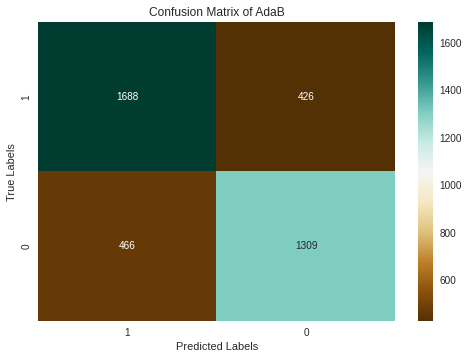

In [788]:
# Plot CM AdaBoost
cm_adab = confusion_matrix(y_test, y_pred_adab)
plotCM(cm_adab, 'AdaB')
plt.savefig('AdaB_CM.png', dpi=300)

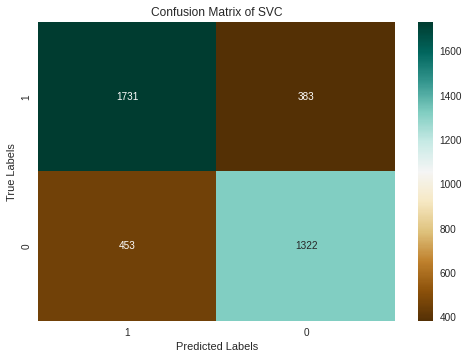

In [789]:
# Plot CM SVC
cm_svc = confusion_matrix(y_test, y_pred_svc)
plotCM(cm_svc, 'SVC')
plt.savefig('SVC_CM.png', dpi=300)

In [790]:
# Calculating classification scores
def modelScores():
  acc = np.array([])
  pre = np.array([])
  rec = np.array([])
  f1 = np.array([])

  for model in [knn_model, adab_model, svc_model]:
    acc = np.append(acc, accuracy_score(y_test, model.predict(X_test_scaled)))
    pre = np.append(pre, precision_score(y_test, model.predict(X_test_scaled)))
    rec = np.append(rec, recall_score(y_test, model.predict(X_test_scaled)))
    f1 = np.append(f1, f1_score(y_test, model.predict(X_test_scaled)))

  return pd.DataFrame([acc, pre, rec, f1], columns = ['KNN','AdaB','SVC']).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy Score', 1: 'Precision Score', 2: 'Recall Score', 3: 'F1 Score',}).round(4)

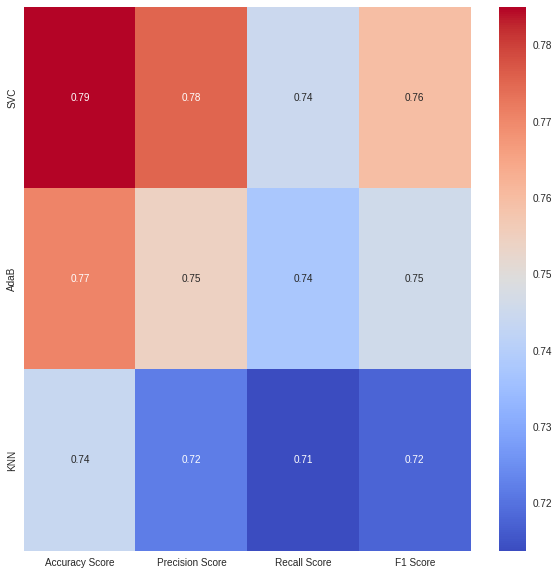

In [791]:
# Plot Heat Map
plt.figure(figsize = (10,10))
sns.heatmap(modelScores(), annot=True, cmap = 'coolwarm')
plt.savefig('HM', dpi=300)
plt.show()

In [792]:
# Calcuating ROC Stats
def ROC(y_score):
    fpr, tpr, thresh = roc_curve(y_test, y_score[:,1], pos_label=1)
    return fpr, tpr, thresh

random_class = [0 for i in range(len(y_test))]
fpr_rand, tpr_rand, _ = roc_curve(y_test, random_class, pos_label=1)

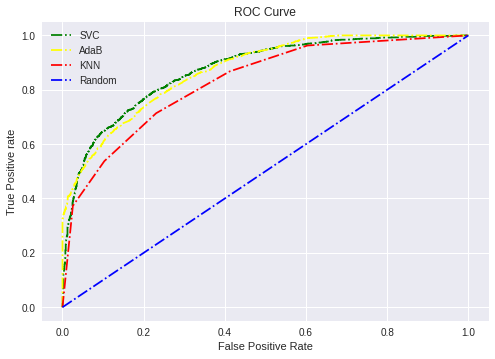

In [793]:
# Plot ROC Graph
plt.style.use('seaborn')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.plot(ROC(y_score_svc)[0], ROC(y_score_svc)[1], linestyle='-.',color='green', label='SVC')
plt.plot(ROC(y_score_adab)[0], ROC(y_score_adab)[1], linestyle='-.',color='yellow', label='AdaB')
plt.plot(ROC(y_score_knn)[0], ROC(y_score_knn)[1], linestyle='-.',color='red', label='KNN')
plt.plot(fpr_rand, tpr_rand, linestyle='-.',color='blue', label='Random')
plt.legend(loc='best')
plt.savefig('ROC.png', dpi=300)
plt.show();